# Comparing Models in scBIVI


In [1]:
%%capture
%pip install scanpy
%pip install scvi-tools==0.8.1
%pip install loompy
%pip install leidenalg

In [2]:
# !python -m pip uninstall matplotlib
# !pip install matplotlib==3.1.3

import matplotlib.pyplot as plt
plt.subplots()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7b7d1793d0>)

ImportError: ignored

<Figure size 432x288 with 1 Axes>

In [3]:

# check GPU availability
import torch 
import torch.nn as nn
import torch.nn.functional as F
memory_used = torch.cuda.memory_allocated()
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


In [4]:
# System
import os, pathlib, time, gc

# Math
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Plots
import matplotlib
#import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# scvi
import anndata
import scvi
import pandas

In [5]:
import sys
sys.path.insert(0,'/content/drive/My Drive/scBIVI_mc/scBIVI/')

In [6]:
# mount to drive and change directory

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/scBIVI_mc/scBIVI/scBIVI/
!ls

Mounted at /content/drive
/content/drive/MyDrive/scBIVI_mc/scBIVI/scBIVI
 analysis.py		    run_scBIVI.py
 Analysis_scBIVI.ipynb	    run.sh
 bivae.py		    scBIVI-10-combined-4-train-history.pdf
 data			   'scBIVI (1).ipynb'
 data_expanded		    scBIVI-3-combined-4-train-history.pdf
 distribution_2.py	    scBIVI-6-combined-4-train-history.pdf
 distribution.py	    scBIVIcustom-10-combined-4-train-history.pdf
 distribution_uni.py	    scBIVIcustom-3-combined-4-train-history.pdf
 download_data.sh	    scBIVIcustom-6-combined-4-train-history.pdf
 experiment_colab.py	    scBIVI.ipynb
 gena_snippets		    scBIVI.py
 out			    scBIVIuncorr-10-combined-4-train-history.pdf
 Prepare_Allen_data.ipynb   scBIVIuncorr-3-combined-4-train-history.pdf
 preprocess.py		    scBIVIuncorr-6-combined-4-train-history.pdf
 __pycache__		    scUNIVI.ipynb
 README.txt		    scUNIVI.py
 reformat_model.ipynb	    test_cluster.png
 reformat_model.py	    test.png
 reformat_model.txt	    umap_6z_corr.svg
 requirements.txt	   

In [7]:
# scbivi scripts
from scBIVI import scBIVI
from analysis import calculate_accuracy, \
                     plot_corr_comparison, \
                     jaccard_index_split, \
                     knn_overlap


Manual scBIVI code

# Load data 

In [8]:
name = 'A08'

adata = anndata.read_loom(f'./data/loom_allen_kb/allen_{name}/counts_subset_concat.loom')

# if 'gene_name' in adata.var.columns:
#     adata.var_names = adata.var['gene_name'].to_list()

# adata.var_names_make_unique()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
adata

AnnData object with n_obs × n_vars = 7896 × 64570
    obs: 'Cluster', 'ID_barcode', 'Sex', 'barcode', 'donor', 'library_id', 'obs_names'
    var: 'Spliced', 'gene_id', 'gene_name', 'var_names'
    layers: 'counts'

In [10]:
# # outdir = 'out/pbmc_10k_v3'
# # datadir = os.path.join(outdir,'data/preprocessed.h5ad')

# adata = anndata.read_h5ad(datadir)
# if 'gene_name' in adata.var.columns:
#     adata.var_names = adata.var['gene_name'].to_list()

# adata.var_names_make_unique()

In [11]:
# Set up train/test data splits with 5-fold split
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
skf_splits = skf.split(adata, adata.obs['Cluster'])

In [12]:
# Use last of the K-fold splits
for k, (train_index, test_index) in enumerate(skf_splits):
  pass

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [13]:
len(test_index)

1579

#  Set up hyperparameters

Define hyper parameters and model (distribution) type

In [14]:
# Hyper-parameters
lr       = 1e-3
n_latent = 20 # overwritten by setup name
n_epochs = 10 
n_hidden = 1024
n_layers = 3

----


# DEFINE DISTRIBUTIONS

In [15]:
def log_prob_MMNB(x: torch.Tensor, mu1: torch.Tensor, mu2: torch.Tensor,
                       theta: torch.Tensor,THETA_IS, eps=1e-8, **kwargs):
    """
    Log likelihood (scalar) of a minibatch according to a bivariate nb model.
    Parameters
    ----------
    x
        data
    mu1,mu2
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars/2)
    theta
        params (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    """

    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)

    if THETA_IS == 'MAT_SHAPE':
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS == 'B':
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS == 'NAS_SHAPE':
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2

    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)
    
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    b = (logmean1 + logmean2 + (logvar1 + logvar2)/2)
    b[b<-88] = -88
    logcov = torch.log(cov * torch.exp(-(b)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)


    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(n+1) - logmean1)
    logvar_cond = logvar2 * (1-logcorr**2)  
    # logstd_cond = logstd2 * torch.sqrt(1-logcorr**2)   
    # logvar_cond = logstd_cond**2


    mean_cond = torch.exp(logmean_cond + logvar_cond/2)
    var_cond = torch.exp(2*logmean_cond + logvar_cond) * (torch.exp(logvar_cond) - 1)

    r = 1/beta
    r_cond = mean_cond**2/(var_cond-mean_cond)
    p_cond = mean_cond/var_cond

    # negative binomial of nascent RNA n
    prefactor = torch.lgamma(n+r) - torch.lgamma(n+1) - torch.lgamma(r) \
                + r * torch.log(r/(r+mu1)+eps) + n * torch.log(mu1/(r+mu1)+eps)


    filt = torch.logical_and(torch.logical_and(r>0,p_cond>0), p_cond<1)

    #compute the Poisson mean
    y_ = m * torch.log(mean_cond+eps) - mean_cond - torch.lgamma(m+1) 

    y_[filt] += torch.lgamma(m[filt]+r_cond[filt]) - torch.lgamma(r_cond[filt]) \
                + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])+eps) \
                - m[filt] * torch.log(r_cond[filt]+mean_cond[filt]+eps) + mean_cond[filt]

    P = prefactor +  y_
    return P

def log_MMNB_same_mean(x: torch.Tensor, mu1: torch.Tensor, mu2: torch.Tensor,
                       theta: torch.Tensor,  THETA_IS, eps=1e-8,**kwargs):
    ''' A test. Same as log_MMNB but with means set to be the same. Because this is unphysical, it should give bad results.'''
    # HERE IS THE CHECK, set the two means equal
    mu2 = mu1

    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)
    
    

    if THETA_IS == 'MAT_SHAPE':
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS == 'B':
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS == 'NAS_SHAPE':
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2

    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)
    
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    b = (logmean1 + logmean2 + (logvar1 + logvar2)/2)
    b[b<-88] = -88
    logcov = torch.log(cov * torch.exp(-(b)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)


    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(n+1) - logmean1)
    logvar_cond = logvar2 * (1-logcorr**2)  
    # logstd_cond = logstd2 * torch.sqrt(1-logcorr**2)   
    # logvar_cond = logstd_cond**2


    mean_cond = torch.exp(logmean_cond + logvar_cond/2)
    var_cond = torch.exp(2*logmean_cond + logvar_cond) * (torch.exp(logvar_cond) - 1)

    r = 1/beta
    r_cond = mean_cond**2/(var_cond-mean_cond)
    p_cond = mean_cond/var_cond

    # negative binomial of nascent RNA n
    prefactor = torch.lgamma(n+r) - torch.lgamma(n+1) - torch.lgamma(r) \
                + r * torch.log(r/(r+mu1)+eps) + n * torch.log(mu1/(r+mu1)+eps)


    filt = torch.logical_and(torch.logical_and(r>0,p_cond>0), p_cond<1)

    #compute the Poisson mean
    y_ = m * torch.log(mean_cond+eps) - mean_cond - torch.lgamma(m+1) 

    y_[filt] += torch.lgamma(m[filt]+r_cond[filt]) - torch.lgamma(r_cond[filt]) \
                + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])+eps) \
                - m[filt] * torch.log(r_cond[filt]+mean_cond[filt]+eps) + mean_cond[filt]

    P = prefactor +  y_
    return P


def log_prob_poisson(x: torch.Tensor, mu1: torch.Tensor, mu2: torch.Tensor,
                       theta: torch.Tensor, eps=1e-8, **kwargs):
    ''' Calculates the uncorrelated Poisson likelihood for nascent and mature: just returns Poisson(n; mu1)*Poisson(m; mu2).'''
    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)

    # DOES NOT USE THETA AT ALL

    #compute the Poisson term for n and m (uncorrelated)
    y_n = n * torch.log(mu1+eps) - mu1- torch.lgamma(n+1) 
    y_m = m * torch.log(mu2+eps) - mu2- torch.lgamma(m+1) 

    P = y_n + y_m
    
    if torch.any(~torch.isfinite(y_)):
        raise ValueError('bad y_')
        
    return P

class direct_MLP(nn.Module):

    def __init__(self, input_size, num_hidden_units, num_hidden_layers, output_size,activate='relu'):
    	super().__init__()
    	self.activate = activate
    	self.module_list = nn.ModuleList([])
    	self.module_list.append(nn.Linear(input_size,num_hidden_units))


    	for k in range(num_hidden_layers-1):
    		self.module_list.append(nn.Linear(num_hidden_units, num_hidden_units))


    	self.module_list.append(nn.Linear(num_hidden_units,output_size))


    def forward(self, x):

    	for f in self.module_list[:-1]:

    		x = f(x)

    		if self.activate == 'relu':
    			x = F.relu(x)
    		elif self.activate == 'sigmoid':
    			x = F.sigmoid(x)

    	x = self.module_list[-1](x)

    	return x

model_path = '/content/drive/My Drive/scBIVI_mc/scBIVI/models/256hidu_3hidl_MODEL' 

# load in model
model_direct = direct_MLP(input_size=5, num_hidden_units=256, num_hidden_layers=3, output_size= 1, activate='relu')
model_direct.load_state_dict(torch.load(model_path))
model_direct.eval()     
model_direct.to(torch.device('cuda'))

def log_prob_direct(x: torch.tensor, mu1: torch.tensor, mu2: torch.tensor,
                       theta: torch.tensor, THETA_IS, eps = 1e-8,  model=model_direct):
    
    
    ''' 
    x : anndata object containing unspliced/spliced RNA
    
    mu1 : mean of nascent RNA (output from DecoderSCVI)
    
    mu2 : mean of mature RNA (output from DecoderSCVI)
    
    theta : shape parameter (NAS or MAT shape , correlation)? 
        -- how to interpret physically ? 
        
    Takes output from SCVI model and calculates the probability of data given the bursty, two-species model of transcription.
    Uses DIRECT model.
    '''

    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)
    
    if THETA_IS == 'MAT_SHAPE':
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS == 'B':
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS == 'NAS_SHAPE':
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2


    # take log and reshape to feed through model
    b_log = torch.log(b).reshape(-1,1)
    beta_log = torch.log(beta).reshape(-1,1)
    gamma_log = torch.log(gamma).reshape(-1,1)

    rate_vectors = torch.column_stack((b_log,beta_log,gamma_log,n.reshape(-1,1),m.reshape(-1,1)))


    # feed rate vectors through model to get weights and hyperparameter
    probabilities = model(rate_vectors)
    print(torch.max(probabilities))
    
    return(probabilities.reshape(theta.shape))

In [15]:
# LOAD IN MY MODEL

!jupyter nbconvert reformat_model.ipynb --to python

[NbConvertApp] Converting notebook reformat_model.ipynb to python
[NbConvertApp] Writing 6769 bytes to reformat_model.py


In [12]:
import reformat_model as reformat_model

In [13]:
log_prob_nnNB  = lambda x,mu1,mu2,theta: reformat_model.get_prob_nnNB(x, mu1, mu2,
                       theta, eps=1e-8, THETA_IS = 'NAS_SHAPE')

-----


# AND TRAIN

The following seed settings work:
```
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
# np.seed(8675309)
np.random.seed(8675309)
```

Define the model setups.

In [104]:
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
# np.seed(8675309)
np.random.seed(8675309)


# Hyper-parameters
lr       = 1e-3
n_epochs = 10
n_hidden = 1024
n_layers = 3

z  = 6
setups = [f'MMNB-{z}',
          f'Direct-{z}',
          f'nnNB-{z}',
          f'NBcorr-{z}',
          f'NBuncorr-{z}',
          f'Poisson-{z}',
          f'Test-{z}'
          ]

# setups = ['nnNB-10']

metrics_list = ['recon_error','latent_embedding','compute','df_history','cluster']
results_dict = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}

In [109]:
for setup in setups:
      
    print(setup)
    method,n_latent = setup.split("-")
    n_latent = int(n_latent)

    adata_in = adata.copy()
    scvi.data.setup_anndata(adata_in, layer="counts")


    if len(train_index)%2 !=0:
      this_train_index = train_index[:-1]
    else:
      this_train_index = train_index
    train_adata, test_adata = adata_in[this_train_index], adata_in[test_index]
    train_adata = train_adata.copy()


    ## Set model parameters
    model_args = {'use_cuda'     : True,
                  'n_latent'     : n_latent,
                  'n_layers'     : n_layers,
                  'dispersion'   : 'gene',
                  'n_hidden'     : n_hidden,
                  'dropout_rate' :  0.1,
                  'gene_likelihood'    :  'nb',
                  'log_variational'    :  True,
                  'latent_distribution':  'normal'
                  }
    #model_args.update(additional_kwargs)

    ## Create model
    if method == 'MMNB':
        custom_dist = log_prob_MMNB
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'Direct':
        custom_dist = log_prob_direct
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'NBcorr':
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == 'NBuncorr':
        model = scBIVI(train_adata,mode='uncorr',**model_args)
    elif method == 'Poisson':
        custom_dist = log_prob_poisson
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == 'nnNB':
        custom_dist = reformat_model.get_prob_nnNB
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'Test':
        custom_dist = log_MMNB_same_mean
        model = scBIVI(train_adata,mode='custom',**model_args)
    else:
        raise Exception('Input valid scVI model')

    ## Train model
    start = time.time()
    model.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)

    runtime     = time.time() - start
    memory_used = torch.cuda.memory_allocated()
    results_dict[setup]['compute'].append([runtime,memory_used])

    ## Check train history
    df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
                  'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
    df_history = pd.DataFrame(df_history)
    df_history = pd.DataFrame(df_history.stack())
    df = df_history
    df.reset_index(inplace=True)
    df.columns = ['Epoch','Loss Type', 'Loss']
    results_dict[setup]['df_history'] = df

    ## Get reconstruction loss on test data
    test_error  = model.get_reconstruction_error(test_adata)
    train_error = model.get_reconstruction_error(train_adata)
    results_dict[setup]['recon_error'].append(np.array([train_error,test_error]))


    # ## GET PARAMS -- this is an interesting one :D 
    # results_dict[setup]['params'] = model.get_likelihood_parameters(adata_in)

    ## Extract the embedding space for scVI
    X_out = model.get_latent_representation(test_adata)
    X_out_full = model.get_latent_representation(adata_in)

    adata.obsm[f'X_{method}'] = X_out_full

    #### Validation with cluster accuracy based on labels
    ## Iterate through ground truth labels based on different approach
    y = test_adata.obs['Cluster']
    y = np.array(y.tolist())

    score_dict = calculate_accuracy(X_out,y)
    results_dict[setup]['cluster'].append(score_dict)

    del model
    torch.cuda.empty_cache()
    gc.collect()

MMNB-6
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 100 cells, 2000 vars, 1 batches, 1 labels, and 0        
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


IndexError: ignored

IndexError: ignored

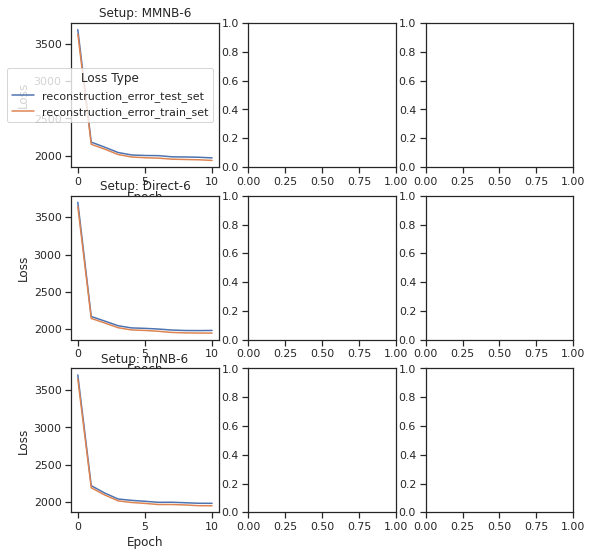

In [ ]:
fig, ax = plt.subplots(3,3,figsize= (9,9))


for i,setup in enumerate(setups):
  if i <= 3:
    k = i
    l = 0
  else:
    k = abs(3-i)
    l = 1

  if i == 0:
    legend = True
  else:
    legend = False
  sns.lineplot(data = results_dict[setup]['df_history'],x='Epoch',y='Loss',hue='Loss Type',ax=ax[k,l],legend=legend)
  ax[k,l].set_title(f'Setup: {setup}')

plt.tight_layout()

# Plot Training/Testing Loss, Accuracy

In [144]:

def plot_recon_loss(results_dict):
  setups = list(results_dict.keys())
  df_plot = pd.concat([pd.DataFrame({"Train": -np.array(r['recon_error'])[:,0],
                                   "Test": -np.array(r['recon_error'])[:,1],
                                   'Setup': key}) for key,r in results_dict.items()])

  df_plot['KFold'] = df_plot.index
  df_plot.reset_index(drop=True)



  fig,ax=plt.subplots()
  _ = sns.barplot(data=df_plot, x='Setup', y='Test', hue='Setup', dodge=False, ax=ax)
  ax.get_legend().remove()
  plt.title('Testing Reconstruction Error')
  plt.xticks(rotation=45)
  return(df_plot)
  # print(df_plot.groupby("Setup").mean())



In [21]:
df_plot

,Train,Test,Setup,KFold
0,24983.948019,25016.363086,MMNB-6,0
0,24930.218631,24970.795994,Direct-6,0
0,24972.910070,25002.004908,nnNB-6,0
0,25024.103180,25066.788236,NBcorr-6,0
0,25101.163751,25124.667946,NBuncorr-6,0
0,24942.598658,24972.822752,Poisson-6,0
0,24949.757521,24991.516783,Test-6,0


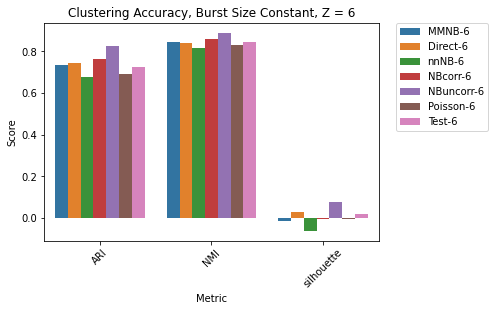

In [22]:

#### Plot clustering accuracy

# iterate through different cluster methods

df_plot = pd.concat([pd.DataFrame(r['cluster']).assign(Setup=key) for key,r in results_dict.items()])
df_plot = df_plot.melt(id_vars=['Setup'],var_name='Metric',value_name='Score')

fig,ax=plt.subplots()
_ = sns.barplot(data=df_plot, x='Metric', y='Score', hue='Setup', ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.title(f'Clustering Accuracy, Burst Size Constant, Z = {z}');

# UMAPs !!!



I know they are hated, but let us just visualize the clustering each different method uses. 

In [23]:
import scanpy as sc
sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [24]:
# first, look at UMAP of leiden clustering on top 40 PCA components
adata

AnnData object with n_obs × n_vars = 7896 × 64570
    obs: 'Cluster', 'ID_barcode', 'Sex', 'barcode', 'donor', 'library_id', 'obs_names', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'Spliced', 'gene_id', 'gene_name', 'var_names'
    uns: '_scvi'
    obsm: 'X_MMNB', 'X_Direct', 'X_nnNB', 'X_NBcorr', 'X_NBuncorr', 'X_Poisson', 'X_Test'
    layers: 'counts'

In [24]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pl.pca(adata,color='Cluster')

Z=6, Method: MMNB


TypeError: ignored

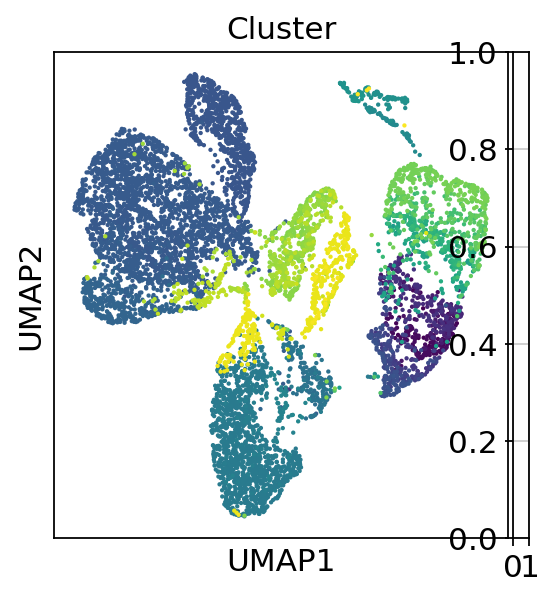

In [25]:
# UMAP using different distributions

for setup in setups:
  method,n_latent = setup.split("-")
  sc.pp.neighbors(adata, use_rep=f"X_{method}")
  sc.tl.umap(adata)
  print(f"Z={n_latent}, Method: {method}")
  sc.pl.umap(adata,
           color="Cluster")

Z=6, Method: MMNB


TypeError: ignored

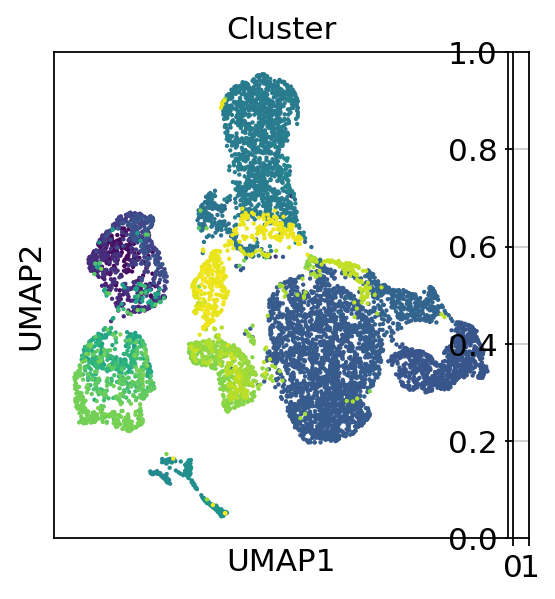

In [32]:
sc.pp.neighbors(adata, use_rep=f"X_Direct")
sc.tl.umap(adata)
print(f"Z={n_latent}, Method: MMNB")
sc.pl.umap(adata,
           color="Cluster")

# Synthetic Data



1. Poisson distribution (uncorrelated for spliced, unspliced)
2. NB distributed (uncorrelated for spliced, unspliced)




In [165]:
from scipy.sparse import csr_matrix


# alternatively, could do this and NOT rely on weird count data :D 
counts = csr_matrix(np.random.poisson(1, size=(500, 2000)))
adata_poisson = anndata.AnnData(counts)
adata_poisson

# counts_nb = csr_matrix(np.random.negative_binomial(1,0.24, size=(100, 2000)))
# adata_nb = anndata.AnnData(counts_nb)
# adata_nb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  


AnnData object with n_obs × n_vars = 500 × 2000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  


AnnData object with n_obs × n_vars = 100 × 2000

### Make Synthetic data using count matrix

In [129]:
counts = csr_matrix.toarray(adata.layers['counts'][:500,:2000])
counts_poisson = csr_matrix(np.random.poisson(counts))
adata_poisson = anndata.AnnData(counts_poisson)
adata_poisson.var = adata.var[:2000]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:
# probabilities will be random numbers between 0 and 1 for each gene 
p_nb = np.random.uniform(low=0.01, high=0.99, size=(1,2000))
np.repeat(p_nb,500,axis=0)


# for later use, p_nb = (mu**2/r)*( mu**2/r + mu)**(-1)
eps = 1e-8
mu = counts
r_nb = mu**2 / ( (mu /(1-p_nb)) - mu + eps) + eps

counts_nb = csr_matrix(np.random.negative_binomial(r_nb,p_nb))
adata_nb = anndata.AnnData(counts_nb)
adata_nb.var = adata.var[:2000]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if sys.path[0] == '':


In [167]:
# run model on this new object and see what happens :D 
adata_poisson.layers['counts'] = adata_poisson.X
adata_nb.layers['counts'] = adata_nb.X

In [177]:
z  = 6
setups = [f'MMNB-{z}',
          f'Direct-{z}',
          f'nnNB-{z}',
          f'NBcorr-{z}',
          f'NBuncorr-{z}',
          f'Poisson-{z}',
          f'Test-{z}'
          ]

# setups = ['nnNB-10']

metrics_list = ['recon_error','latent_embedding','compute','df_history','params']
results_dict_nb = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}

In [178]:
for setup in setups:
      
    print(setup)
    method,n_latent = setup.split("-")
    n_latent = int(n_latent)

    adata_in = adata_nb.copy()
    scvi.data.setup_anndata(adata_in, layer="counts")

    train_adata = adata_in[:400]
    test_adata = adata_in[400:]

    train_adata = train_adata.copy()


    ## Set model parameters
    model_args = {'use_cuda'     : True,
                  'n_latent'     : n_latent,
                  'n_layers'     : n_layers,
                  'dispersion'   : 'gene',
                  'n_hidden'     : n_hidden,
                  'dropout_rate' :  0.1,
                  'gene_likelihood'    :  'nb',
                  'log_variational'    :  True,
                  'latent_distribution':  'normal'
                  }
    #model_args.update(additional_kwargs)

    ## Create model
    if method == 'MMNB':
        custom_dist = log_prob_MMNB
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'Direct':
        custom_dist = log_prob_direct
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'NBcorr':
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == 'NBuncorr':
        model = scBIVI(train_adata,mode='uncorr',**model_args)
    elif method == 'Poisson':
        custom_dist = log_prob_poisson
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == 'nnNB':
        custom_dist = reformat_model.get_prob_nnNB
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'Test':
        custom_dist = log_MMNB_same_mean
        model = scBIVI(train_adata,mode='custom',**model_args)
    else:
        raise Exception('Input valid scVI model')

    ## Train model
    start = time.time()
    model.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)

    runtime     = time.time() - start
    memory_used = torch.cuda.memory_allocated()
    results_dict_nb[setup]['compute'].append([runtime,memory_used])

    ## Check train history
    df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
                  'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
    df_history = pd.DataFrame(df_history)
    df_history = pd.DataFrame(df_history.stack())
    df = df_history
    df.reset_index(inplace=True)
    df.columns = ['Epoch','Loss Type', 'Loss']
    results_dict_nb[setup]['df_history'] = df

    ## Get reconstruction loss on test data
    test_error  = model.get_reconstruction_error(test_adata)
    train_error = model.get_reconstruction_error(train_adata)
    results_dict_nb[setup]['recon_error'].append(np.array([train_error,test_error]))


    # ## GET PARAMS -- this is an interesting one :D 
    results_dict_nb[setup]['params'] = model.get_likelihood_parameters(adata_in)

    ## Extract the embedding space for scVI
    X_out = model.get_latent_representation(train_adata)
    X_out_full = model.get_latent_representation(adata_in)

    adata_nb.obsm[f'X_{method}'] = X_out_full

    del model
    torch.cuda.empty_cache()
    gc.collect()

MMNB-6
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 500 cells, 2000 vars, 1 batches, 1 labels, and 0        
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Training for 10 epochs                                                                                    
INFO     KL warmup for 5.0 epochs                                

,Train,Test,Setup,KFold
0,4109.557363,5672.026875,MMNB-6,0
0,4050.542773,5412.613750,Direct-6,0
0,4632.136318,6231.781250,nnNB-6,0
0,5924.287676,6348.731250,NBcorr-6,0
0,6935.867637,6801.931250,NBuncorr-6,0
0,5800.704648,7284.728125,Poisson-6,0
0,8773.329961,9938.582500,Test-6,0


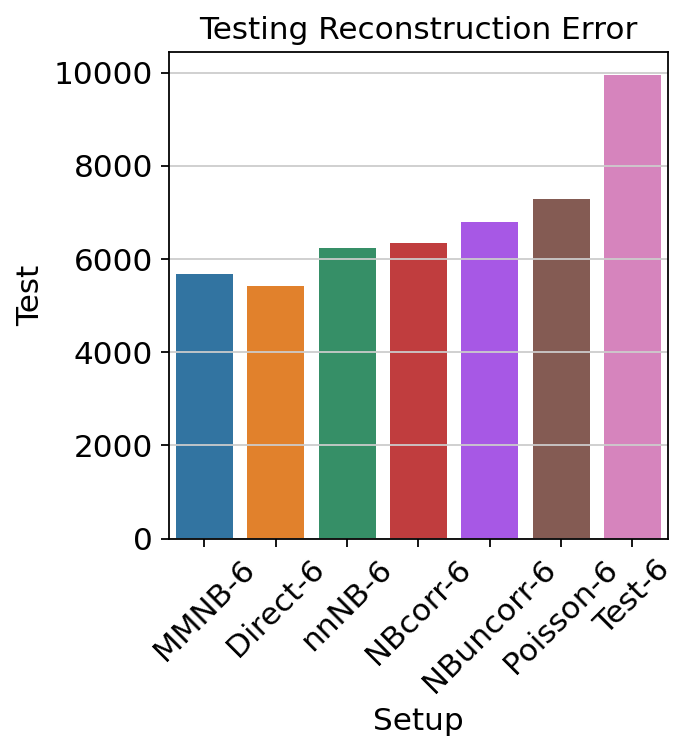

In [179]:
df_plot = plot_recon_loss(results_dict_nb)
df_plot

In [180]:
counts_nb =  csr_matrix.toarray(adata_nb.layers['counts'])
means_to_plot = counts_nb.flatten()

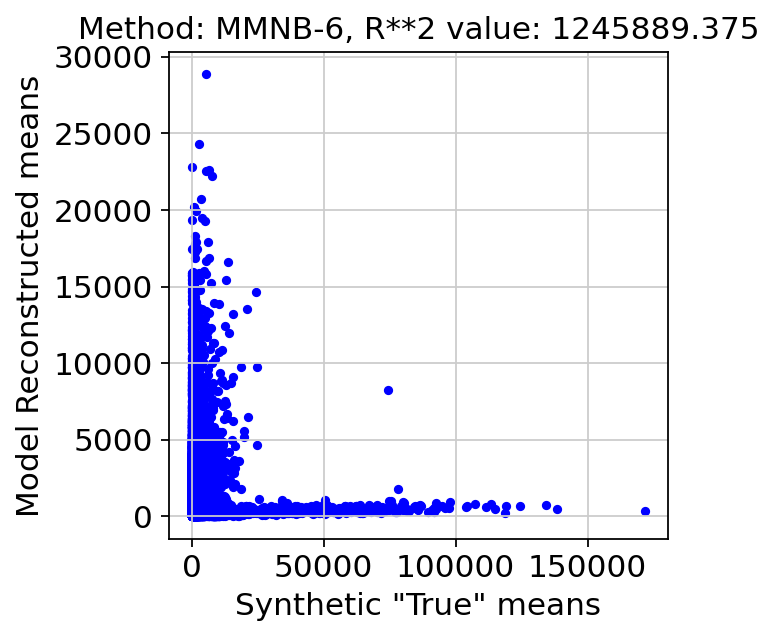

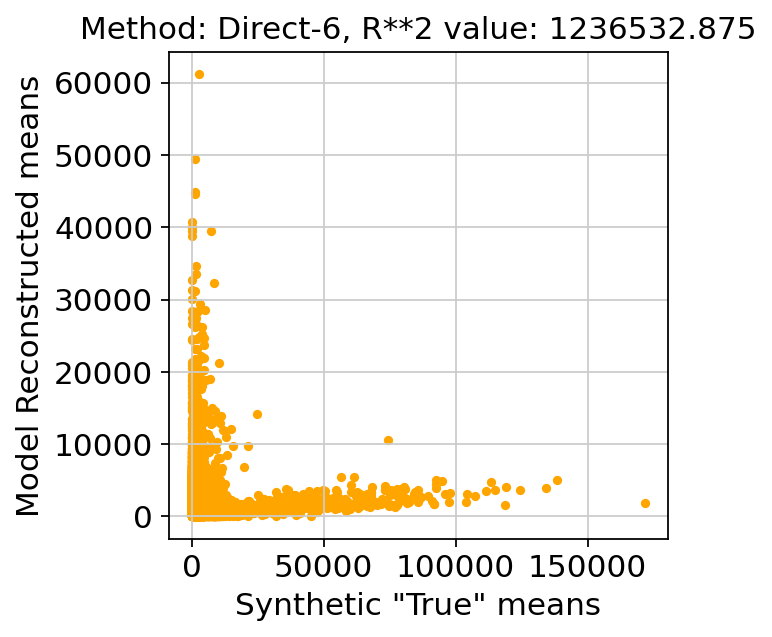

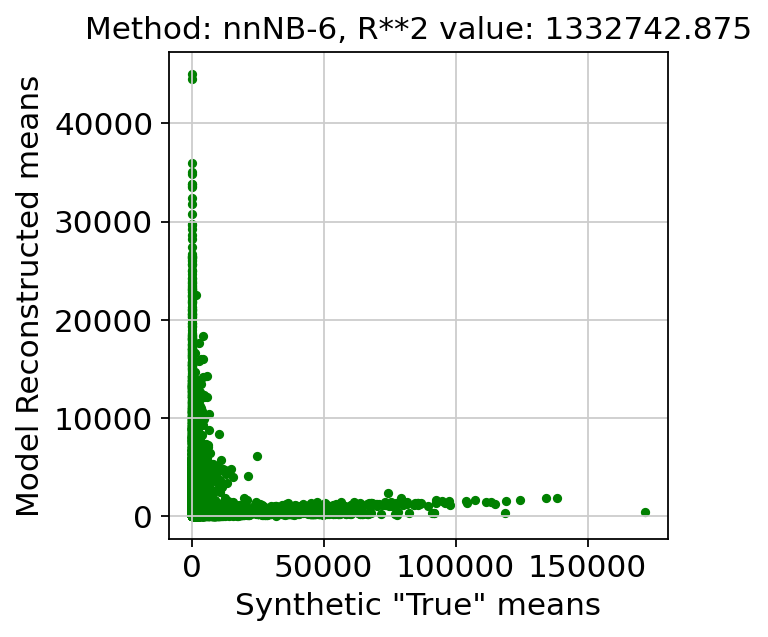

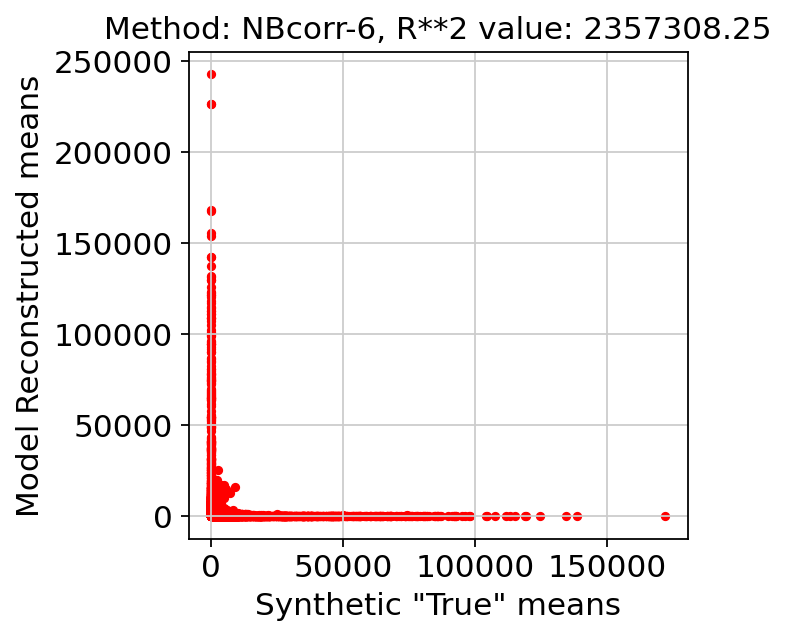

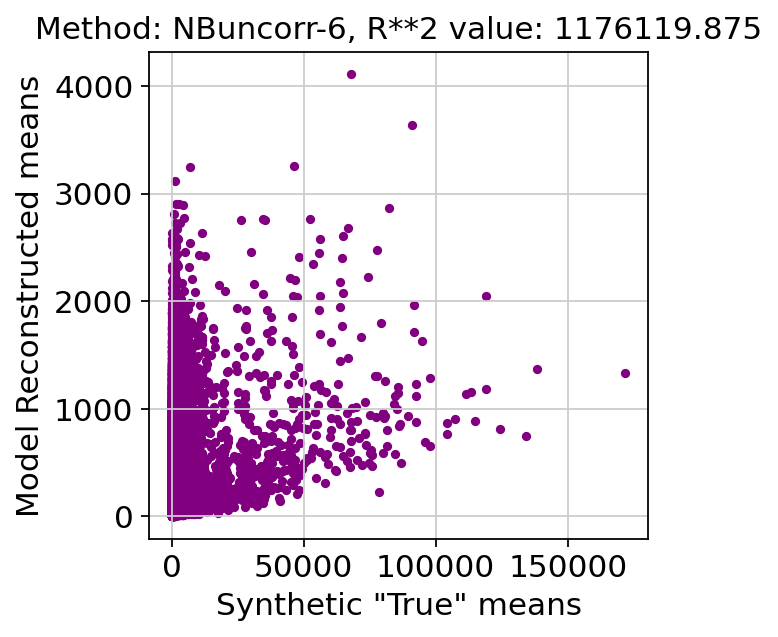

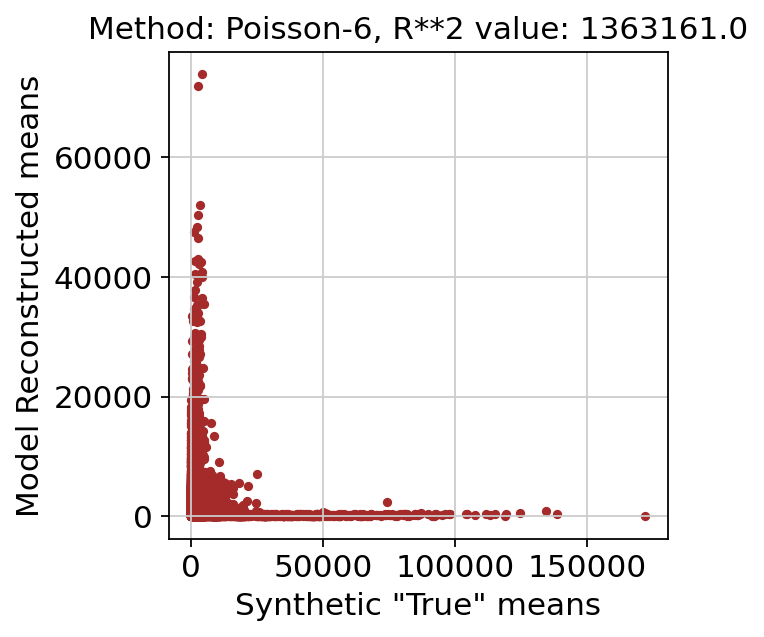

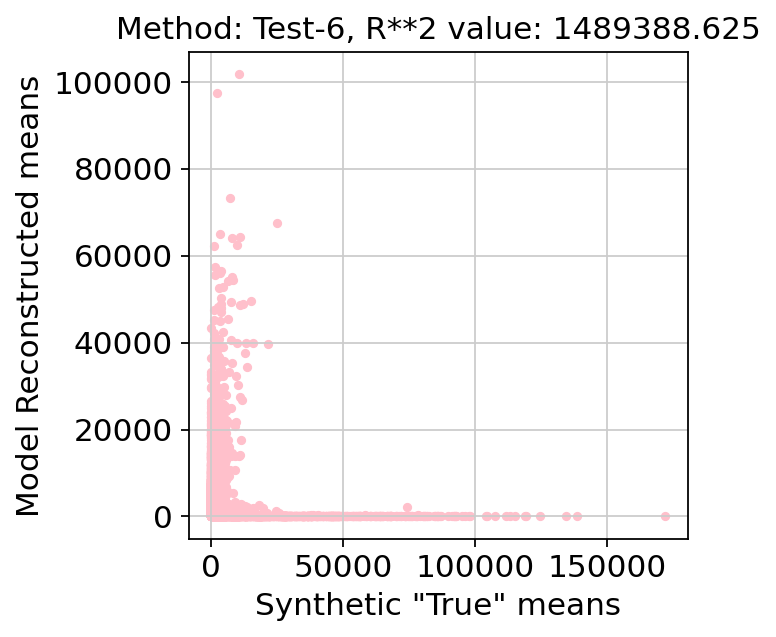

In [181]:
colors = ['blue','orange','green','red','purple','brown','pink']

for i,setup in enumerate(setups):

  recon_means =  results_dict_nb[setup]['params']['mean']
  recon_means = recon_means.flatten()
  plt.scatter(means_to_plot,recon_means,s=10,c=colors[i])
  plt.xlabel('Synthetic "True" means')
  plt.ylabel('Model Reconstructed means')
  r2 = np.mean((recon_means-means_to_plot)**2)
  plt.title(f'Method: {setup}, R**2 value: {r2}')
  # plt.xlim(0,100)
  # plt.ylim(0,25)
  #plt.plot(range(200),range(200),c='black',label='y=x')

  plt.show()